
# Exemplo de Caso em que GD tem Dificuldade: Regressão de Seno


In [1]:
from typing import Optional, Union, Any
from collections.abc import Iterable
from abc import ABC, abstractmethod
import numbers

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Descida de Gradiente com Pytorch

O trecho abaixo mostra como utilizar o sistema de diferenciação automática do Pytorch e o algoritmo de descida do gradiente para encontrar o mínimo da função $f(x_1, x_2) = x_1^2 + x_2^2$.

In [45]:

x = torch.tensor([13.0, 15.0], requires_grad=True)
lr = 0.2

for step in range(10):
    y = torch.sum(x ** 2)
    y.backward()

    # o torch.no_grad() necessário para evitar que a soma
    # do gradiente em x seja adicionada no grafo computacional.
    with torch.no_grad():
        # passo de descida do gradiente
        x -= lr * x.grad

    x.grad.zero_()

    print("step:", step, "loss:", y.detach().numpy(), "x:", x.detach().numpy())


step: 0 loss: 394.0 x: [7.7999997 9.       ]
step: 1 loss: 141.84 x: [4.68      5.3999996]
step: 2 loss: 51.062393 x: [2.8079998 3.2399998]
step: 3 loss: 18.382462 x: [1.6847999 1.9439999]
step: 4 loss: 6.6176863 x: [1.01088 1.1664 ]
step: 5 loss: 2.3823671 x: [0.606528   0.69983995]
step: 6 loss: 0.8576522 x: [0.36391678 0.41990396]
step: 7 loss: 0.30875477 x: [0.21835007 0.2519424 ]
step: 8 loss: 0.111151725 x: [0.13101004 0.15116543]
step: 9 loss: 0.040014617 x: [0.07860602 0.09069926]


## Caso Difícil para o GD: Regressão de Funções Periódicas

Considere a tarefa de regressão que consiste em encontrar parâmetros $a$ e $m$ que fazem a função $\sin(mx + a)$ melhor se ajustarem à um conjunto de dados usando a soma de erros quadráticos como função de erro: 

$$
a, m = \argmin_{a, m} \sum_{x_i, y_i} \left[y_i - \sin \left( mx_i + a \right)\right]^2
$$

Vamos tentar usar o algoritmo de descida do gradiente para resolver este problema.

A célula abaixo gera os pontos do dataset de treinamento para $m=5$ e $a=4$.

In [59]:

import numpy as np

def true_fn(x):
    return np.sin(x * 5 + 4)

x = np.arange(-3.0, 3.0, 0.2)
true_y = true_fn(x)
true_y += np.random.normal(size=true_y.shape) * 0.1 * (true_y.max() - true_y.min())

print("x:\n", x)
print("y:\n", true_y)


x:
 [-3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  2.66453526e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00]
y:
 [ 0.74546884  0.30176606 -0.21897344 -0.88115603 -0.48934179 -0.03480892
  0.83890936  0.96238191 -0.4944373  -0.83578724 -0.82516138 -0.13596701
  0.89032488  0.38007728  0.20934693 -0.80343239 -1.12353732 -0.26962281
  0.60417116  1.16607212  0.25533237 -0.39252328 -1.35377127 -0.63973746
  0.48286116  0.86443426  0.43980729 -0.02075501 -0.98660845 -0.64706907]


Visualização dos dados de treinamento.

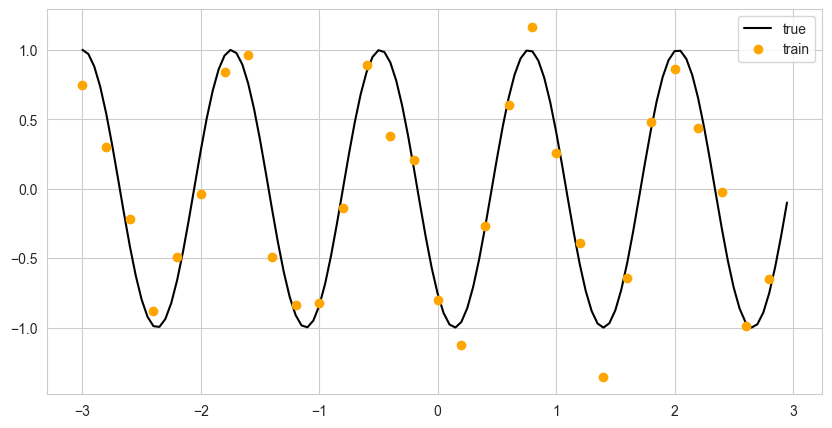

In [60]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = true_fn(all_x)

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(x, true_y, 'o', color='orange', label='train')
plt.legend()
plt.show()

Define o modelo contendo os parâmetros treináveis $a$ e $m$ com valores iniciais de $a=1$ e $m=1$.

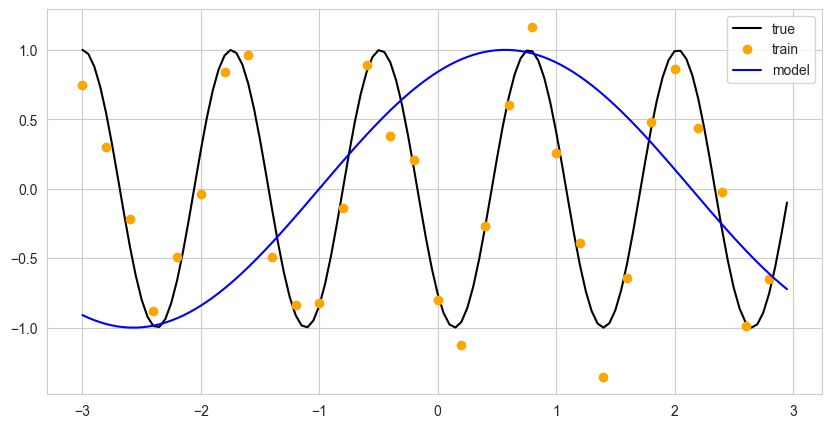

In [61]:

class TorchModel:
    def __init__(self, init_m, init_a):
        # parametros do modelo
        self.m = torch.tensor(float(init_m), requires_grad=True)
        self.a = torch.tensor(float(init_a), requires_grad=True)

    def zero_grad(self):
        # zera os gradientes
        if self.m.grad:
            self.m.grad.zero_()
            self.a.grad.zero_()

    def forward(self, x):
        return torch.sin(x * self.m + self.a)

    def gradient_descent_step(self, learning_rate):
        with torch.no_grad():
            self.m -= learning_rate * self.m.grad
            self.a -= learning_rate * self.a.grad

model = TorchModel(1, 1)

preds = [model.forward(x_i).detach().numpy() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(x, true_y, 'o', color='orange', label='train')
plt.plot(all_x, preds, '-', color='blue', label='model')
plt.legend()
plt.show()

Ajusta os parâmetros usando gradient descent.

In [64]:

n_epochs = 1000
learning_rate = 0.01

model = TorchModel(1, 1)

def ds_loss(x, y, model):
    with torch.no_grad():
        preds = [model.forward(x_i) for x_i in x]

    preds = np.array(preds)
    diff = (preds - y)
    return np.sum(diff ** 2)


history = [
    [model.m.detach().numpy().copy(),
     model.a.detach().numpy().copy(),
     ds_loss(x, true_y, model)]
]

for epoch in range(n_epochs):
    avg_loss = 0
    model.zero_grad()

    count = 0

    for x_i, y_i in zip(x, true_y):

        pred = model.forward(x_i)
        loss = (pred - y_i) ** 2
        loss.backward()
        avg_loss += loss.detach().numpy()

        count += 1

    history.append([
        model.m.detach().numpy().copy(),
        model.a.detach().numpy().copy(),
        avg_loss
    ])

    model.gradient_descent_step(learning_rate)

    if epoch % (n_epochs // 10) == 0:
        print(f"epoch {epoch}: {avg_loss}")

history.append([model.m.detach().numpy().copy(), model.a.detach().numpy().copy(), avg_loss])

epoch 0: 29.506690979003906
epoch 100: 25.27147102355957
epoch 200: 25.271474838256836
epoch 300: 25.271474838256836
epoch 400: 25.271474838256836
epoch 500: 25.271474838256836
epoch 600: 25.271474838256836
epoch 700: 25.271474838256836
epoch 800: 25.271474838256836
epoch 900: 25.271474838256836


Plota a evolução da loss function.

‼️ **Observe que a loss não diminuiu tanto assim e saturou em um erro de 25!** 

Text(0, 0.5, 'loss value')

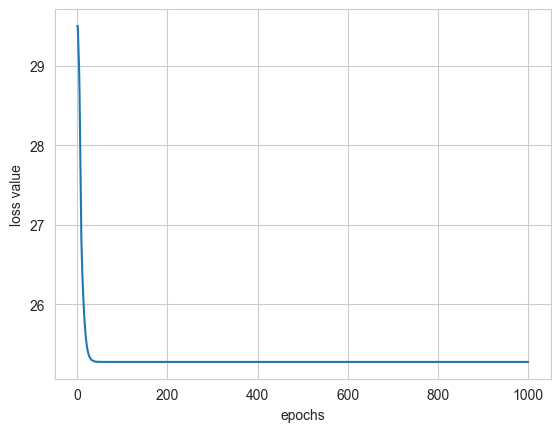

In [77]:
plt.plot([h[2] for h in history])
plt.xlabel('epochs')
plt.ylabel('loss value')


‼️ **A célula abaixo mostra o modelo final e ele não ficou bem ajustado!**

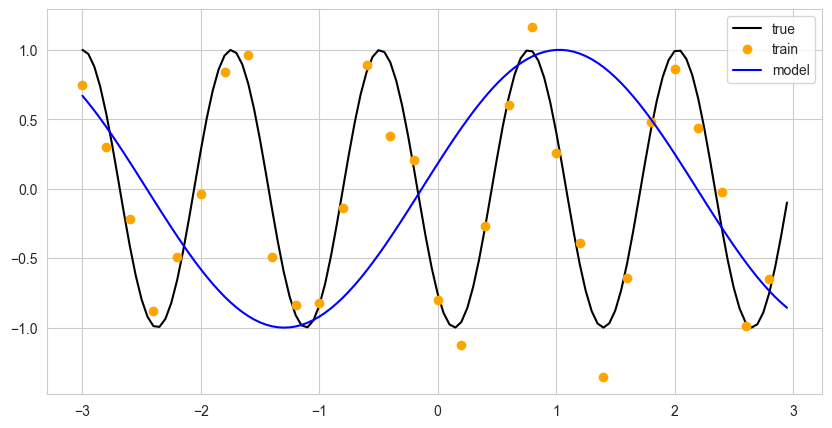

In [65]:
with torch.no_grad():
    preds = [model.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(x, true_y, 'o', color='orange', label='train')
plt.plot(all_x, preds, '-', color='blue', label='model')
plt.legend()
plt.show()

## O que aconteceu?

Por que será que o algoritmo de descida do gradiente não foi capaz de encontrar os valores dos parâmetros? 

Para responder esta questão, vamos aproveitar que o problema só tem 2 parâmetros ($a$ e $m$) e plotar a **superfície do erro** para o problema, isto é, um gráfico mostrando o valor da loss function para diferentes valores dos parâmetros. Para ganhar ainda mais informação, vamos mostrar como os valores dos parâmetros mudaram como resultado da descida do gradiente.


In [66]:
import plotly.graph_objects as go

A = np.linspace(0, 7, 200)
M = np.linspace(0, 7, 200)
A, M = np.meshgrid(A, M)
L = np.zeros_like(A)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        L[i, j] = np.sum((true_y - (np.sin(x * M[i, j] + A[i, j]))) ** 2)

history_np = np.array(history)
m_path = history_np[:, 0].squeeze()
a_path = history_np[:, 1].squeeze()
l_path = history_np[:, 2].squeeze()

# Create the 3D plot
fig = go.Figure()

# Function surface
fig.add_trace(go.Surface(
    z=L, x=A, y=M,
    colorscale='Viridis',
    opacity=0.5,
    showscale=False,
    name='Surface'))

# Descent path
fig.add_trace(go.Scatter3d(
    x=a_path,
    y=m_path,
    z=l_path,
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=4, color='red'),
    name='Gradient Descent Path'
))

# Layout
fig.update_layout(
    title='Gradient Descent Path on f(x, y)',
    scene=dict(
        xaxis_title='additive',
        yaxis_title='multiplicative',
        zaxis_title='f(x, y)',
        aspectmode='manual',  # Set fixed aspect ratio
        aspectratio=dict(x=1.5, y=1.5, z=0.7)  # Tweak this for better visuals
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=100, t=50)
)

fig.show()


Olhe que interessante! Podemos tirar várias conclusões analisando este gráfico: 
- O mínimo global está em $m=5$ e $a=4$, como esperado, dado que estes são os valores reais dos parâmetros.
- A superfície do erro é altamente não linear e possui vários mínimos e máximos.
- Partindo do ponto inicial $(m=1, a=1)$, o algoritmo converge para um mínimo local e seria muito difícil chegar ao mínimo global desta posição inicial.
- Embora o valor inicial $(m=6, a=1)$ leve à um erro muito pior que $(m=1, a=1)$, o algoritmo seria capaz de convergir para o mínimo global deste ponto de partida. Verifique executando o código novamente deste ponto de partida.

**Conclusão:** Embora a tarefa seja aparentemente simples, é bastante difícil para o algortimo de descida do gradiente resolvê-la devido ao grande número de extremos (mínimos e máximos) na superfície do erro. 

A célula abaixo demonstra outra forma de visualizar a superfície do erro, desta vez em 2D.

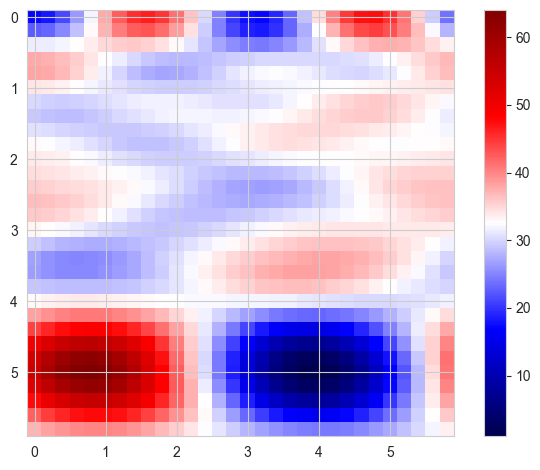

In [ ]:

from itertools import product

n = 6
vals = np.arange(0, 6, 0.2)
img = np.zeros((len(vals), len(vals)))

for i, j in product(range(len(vals)), range(len(vals))):
    img[i][j] = np.sum((np.sin(vals[i] * x + vals[j]) - true_y) ** 2)

hm = plt.imshow(img, cmap='seismic');

#ticks = [str(a) for a in [0, 0.2, 0.4, 0.6, 0.8, 1]]
plt.xticks(range(0, len(vals), len(vals)// 6), range(6));
plt.yticks(range(0, len(vals), len(vals)// 6), range(6));

cb = plt.colorbar(hm);
plt.tight_layout();
